In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data.

In [10]:
df1 = pd.read_pickle('Mc_Gar_Sant')

Apply signal-to-noise cuts and remove negative parallaxes.

In [11]:
sn = df1.parallax.values/df1.parallax_error.values

m = (sn > 10) * (df1.parallax.values > 0) * np.isfinite(df1.parallax.values)
df2 = df1.iloc[m]
print(np.shape(df2))

(35611, 170)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Calculate reddening and extinction from dust using a dust map.

In [12]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.884 s
  pix_info:   0.478 s
   samples:   9.129 s
      best:   4.301 s
       nan:   0.208 s
      sort:   6.533 s
       idx:   0.234 s


In [16]:
coords = SkyCoord(df2.ra.values*units.deg, df2.dec.values*units.deg,
                  distance=(1./(df2.parallax.values*1e-3))*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)
print(np.shape(df2), np.shape(Av))

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

df2["ebv"] = ebv[:, 1]  # The median ebv value.
df2["Av"] = Av
df2["Av_errp"] = Av_errp
df2["Av_errm"] = Av_errm
df2["Av_std"] = Av_std

from tools import getDust
    
AG, Abp, Arp = getDust(df2.phot_g_mean_mag.values, df2.phot_bp_mean_mag.values,
                       df2.phot_rp_mean_mag.values, df2.ebv.values)

df2["bp_dered"] = df2.phot_bp_mean_mag.values - Abp
df2["rp_dered"] = df2.phot_rp_mean_mag.values - Arp
df2["bprp_dered"] = df2["bp_dered"] - df2["rp_dered"]
df2["G_dered"] = df2.phot_g_mean_mag.values - AG

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

(35611, 175) (35611,)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Calculate absolute magnitude:

In [17]:
def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(df2.G_dered.values, 1./(df2.parallax.values*1e-3))
df2["abs_G"] = abs_G

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Remove nans.

In [18]:
m2 = np.isfinite(df2.abs_G.values)
df3 = df2.iloc[m2]

Plot stars on the CMD.

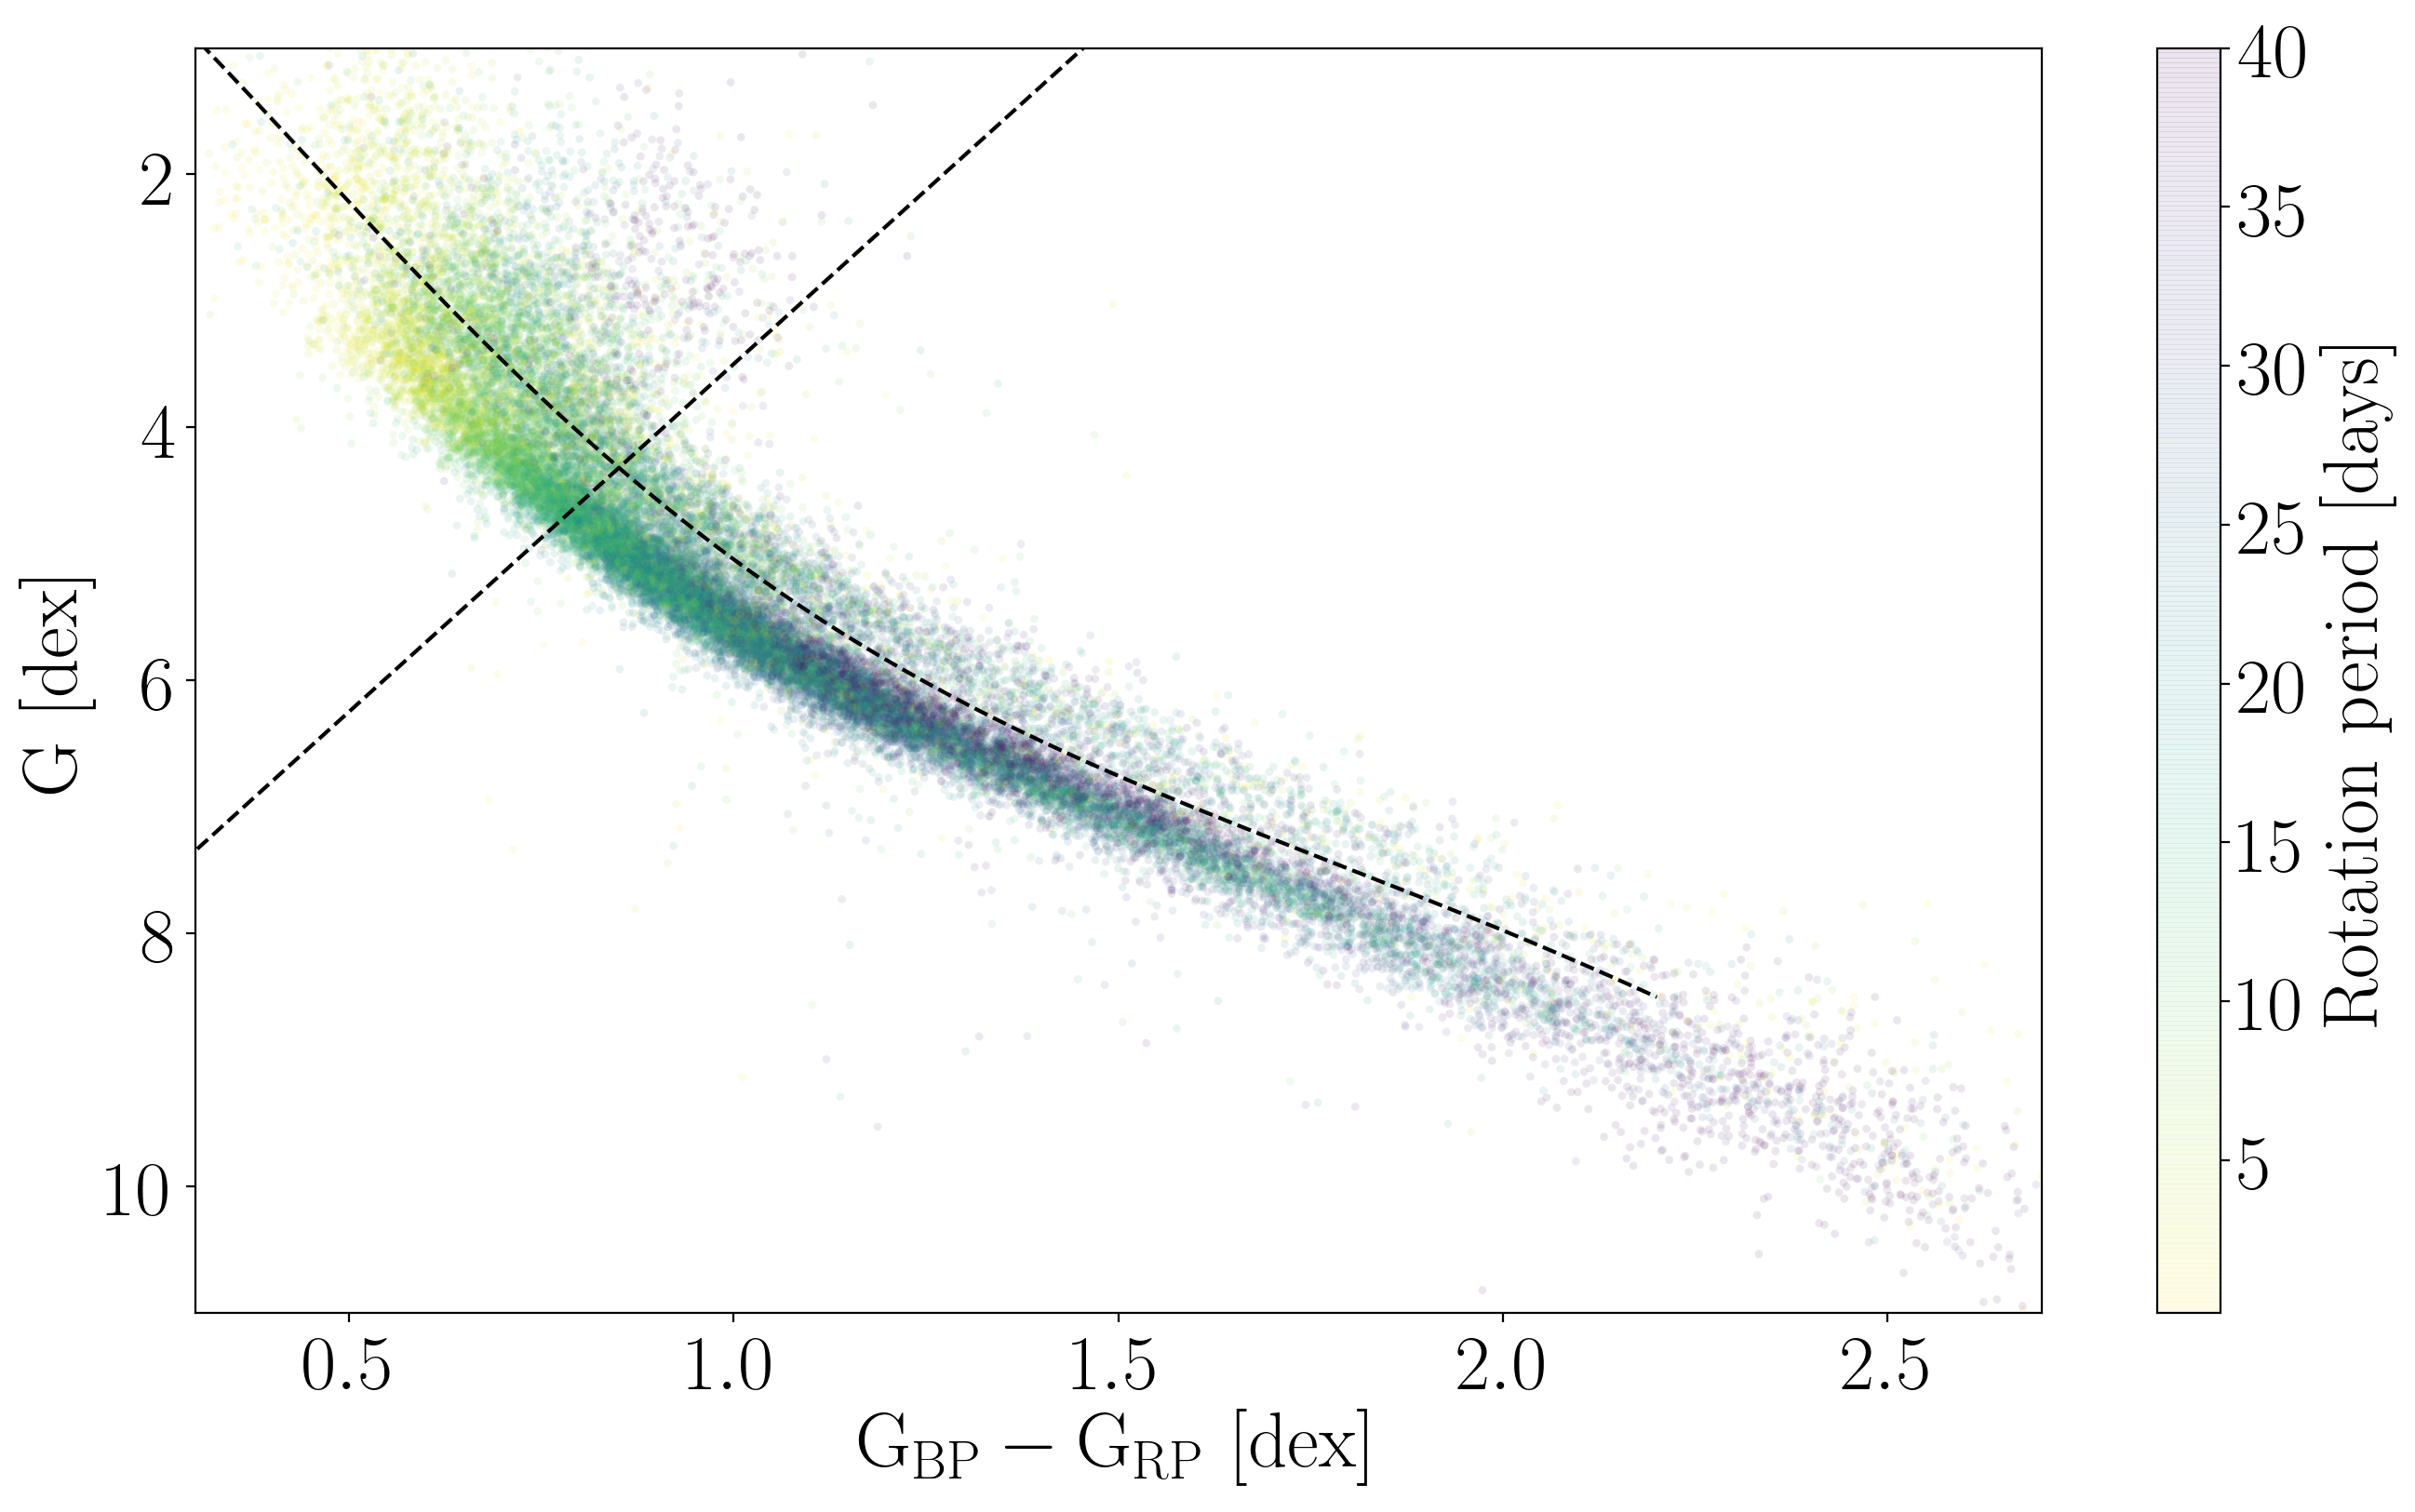

In [48]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df3.bp_dered - df3.rp_dered, df3.abs_G,
            c=df3.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.3, 2.7);

# Fit a polynomial
x = df3.bp_dered - df3.rp_dered
y = df3.abs_G

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 0, 2.2, .25
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
plt.plot(xs, -5.5*xs + 9, "k--")

Cut out the binaries

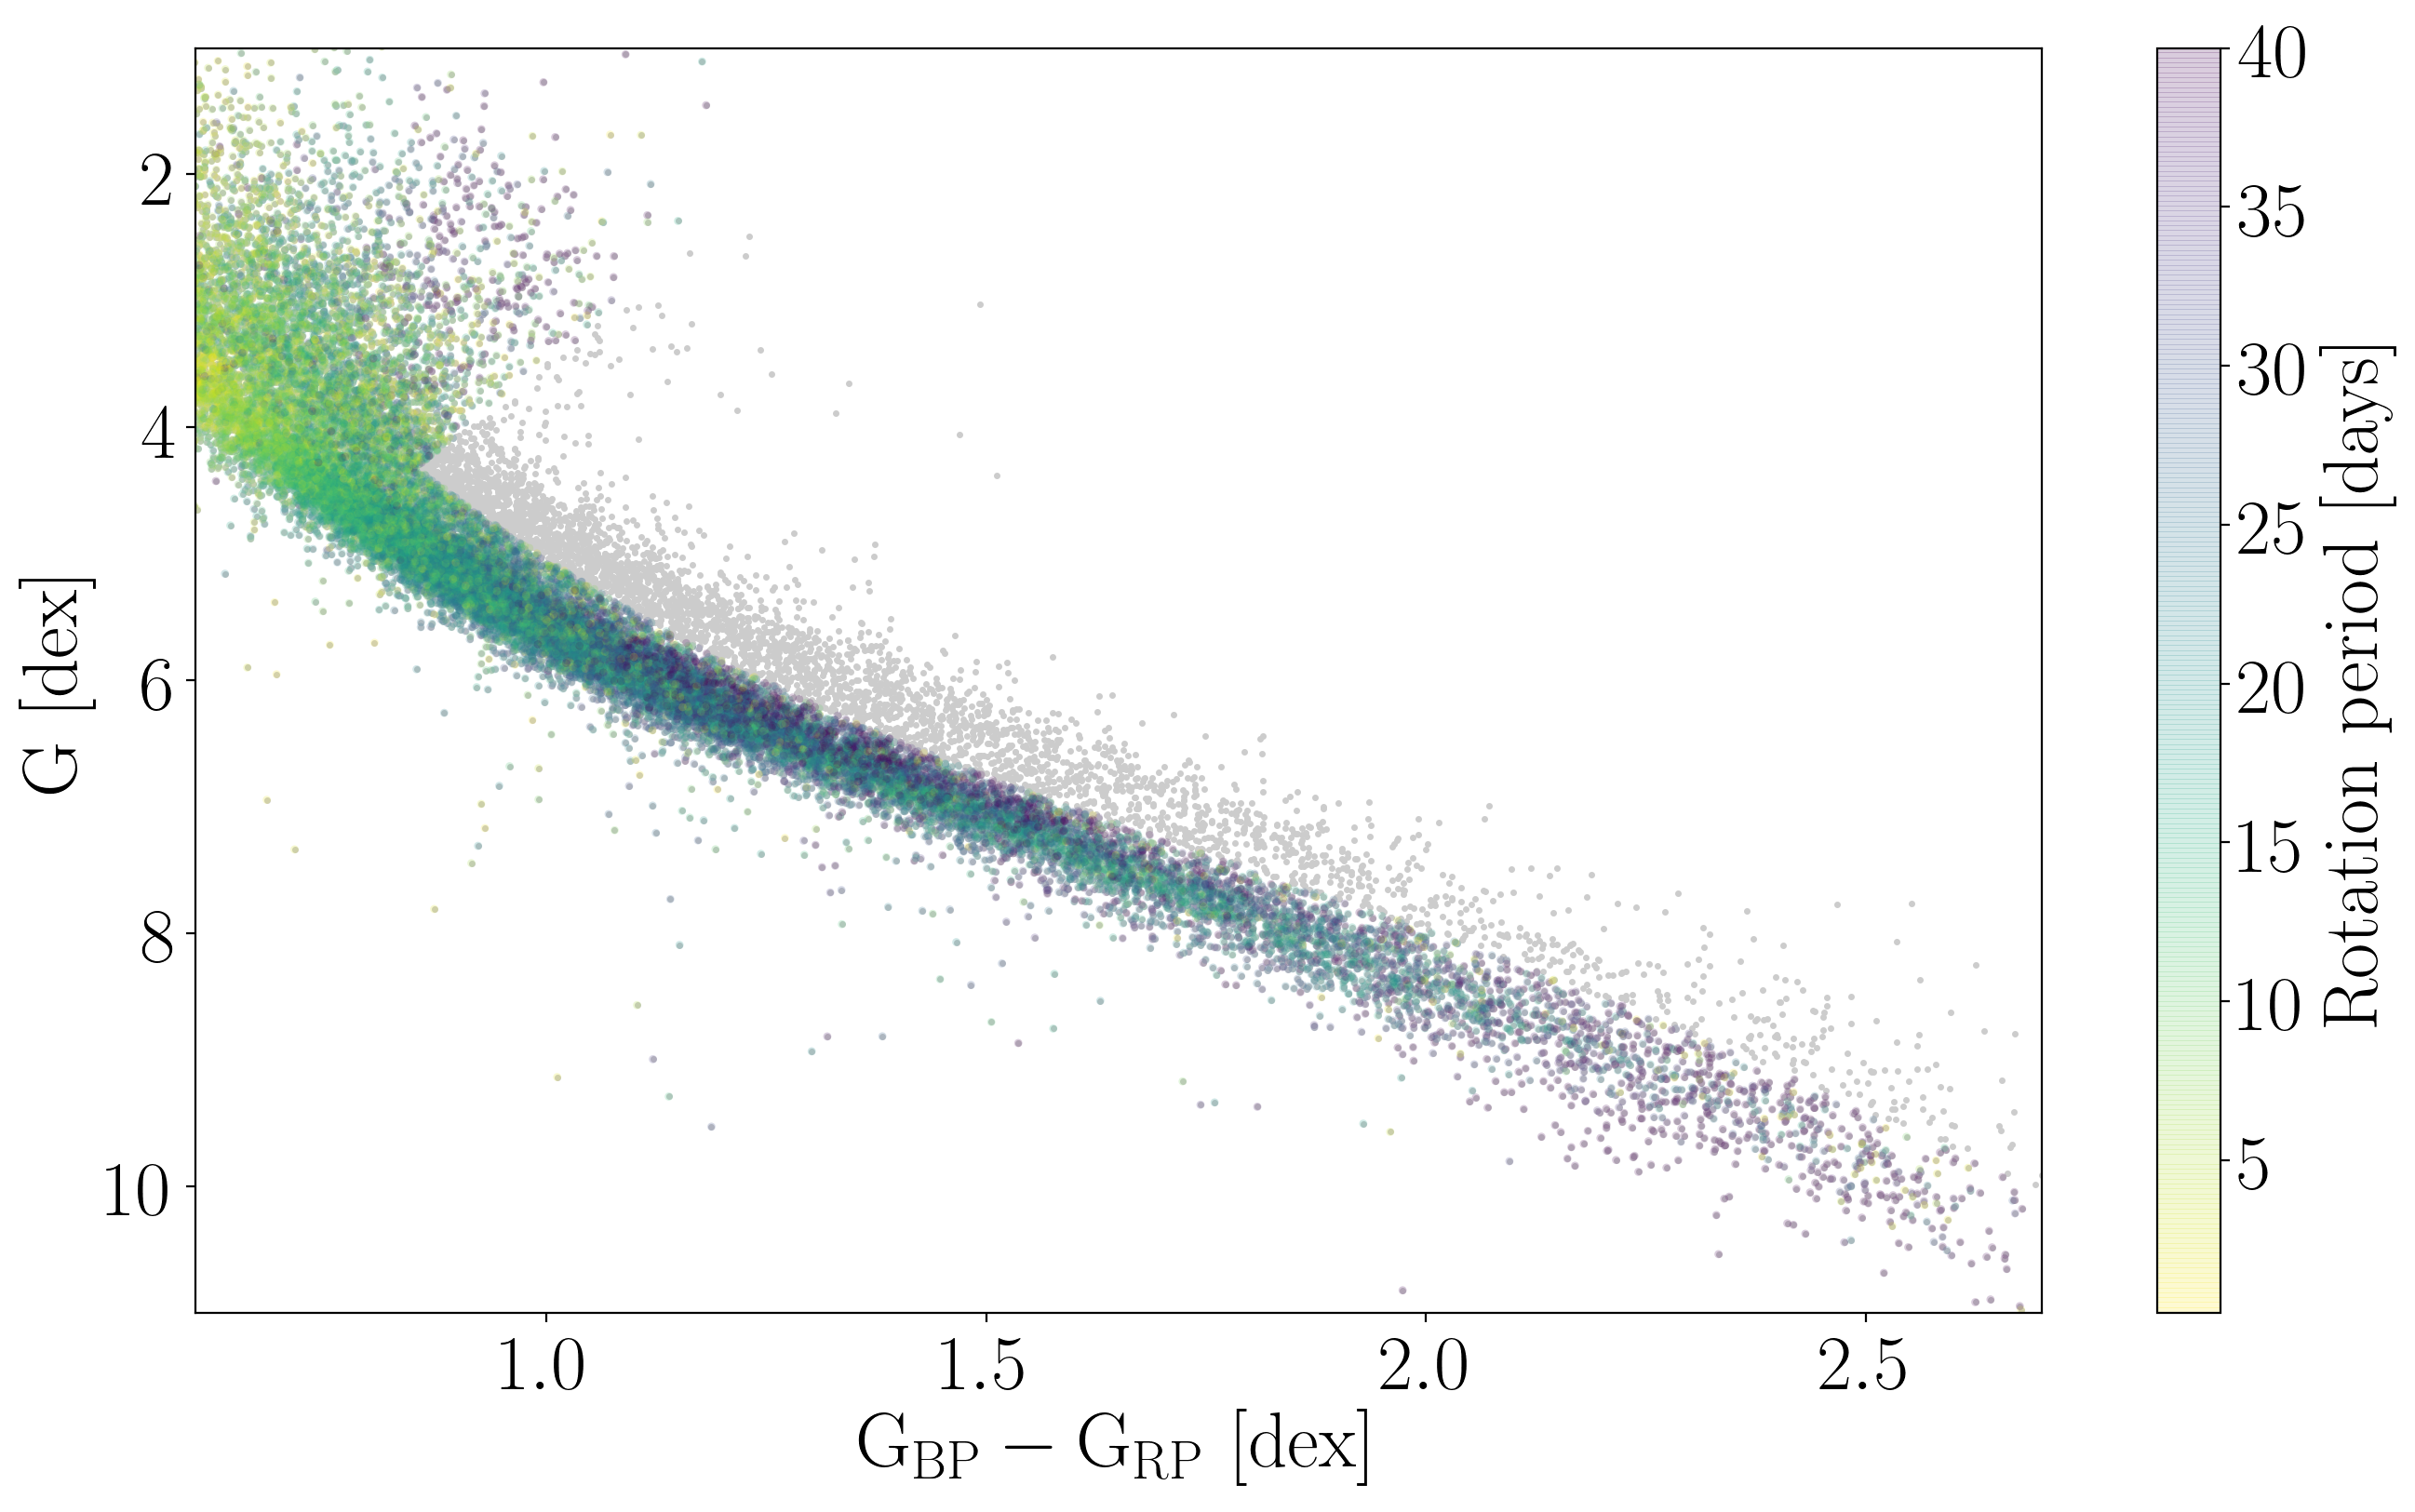

In [49]:
m = (y < np.polyval(w, x) - extra)
m &= (y > -5.5*x + 9)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(x, y, ".", c=".8", zorder=0, ms=3)
plt.scatter(x[~m], y[~m], c=df3.Prot[~m],
            s=10, alpha=.2, cmap="viridis_r", vmax=40, zorder=1,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.6, 2.7);

In [62]:
flag = np.zeros(len(df3))
flag[~m] = np.ones(len(flag[~m])) 
df3["flag"] = flag
# bool_flag = np.ones(len(flag), type="bool")
bool_flag = flag == 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
df = df3.iloc[bool_flag]

In [64]:
print(np.shape(df), np.shape(df3))

(31749, 181) (35570, 181)


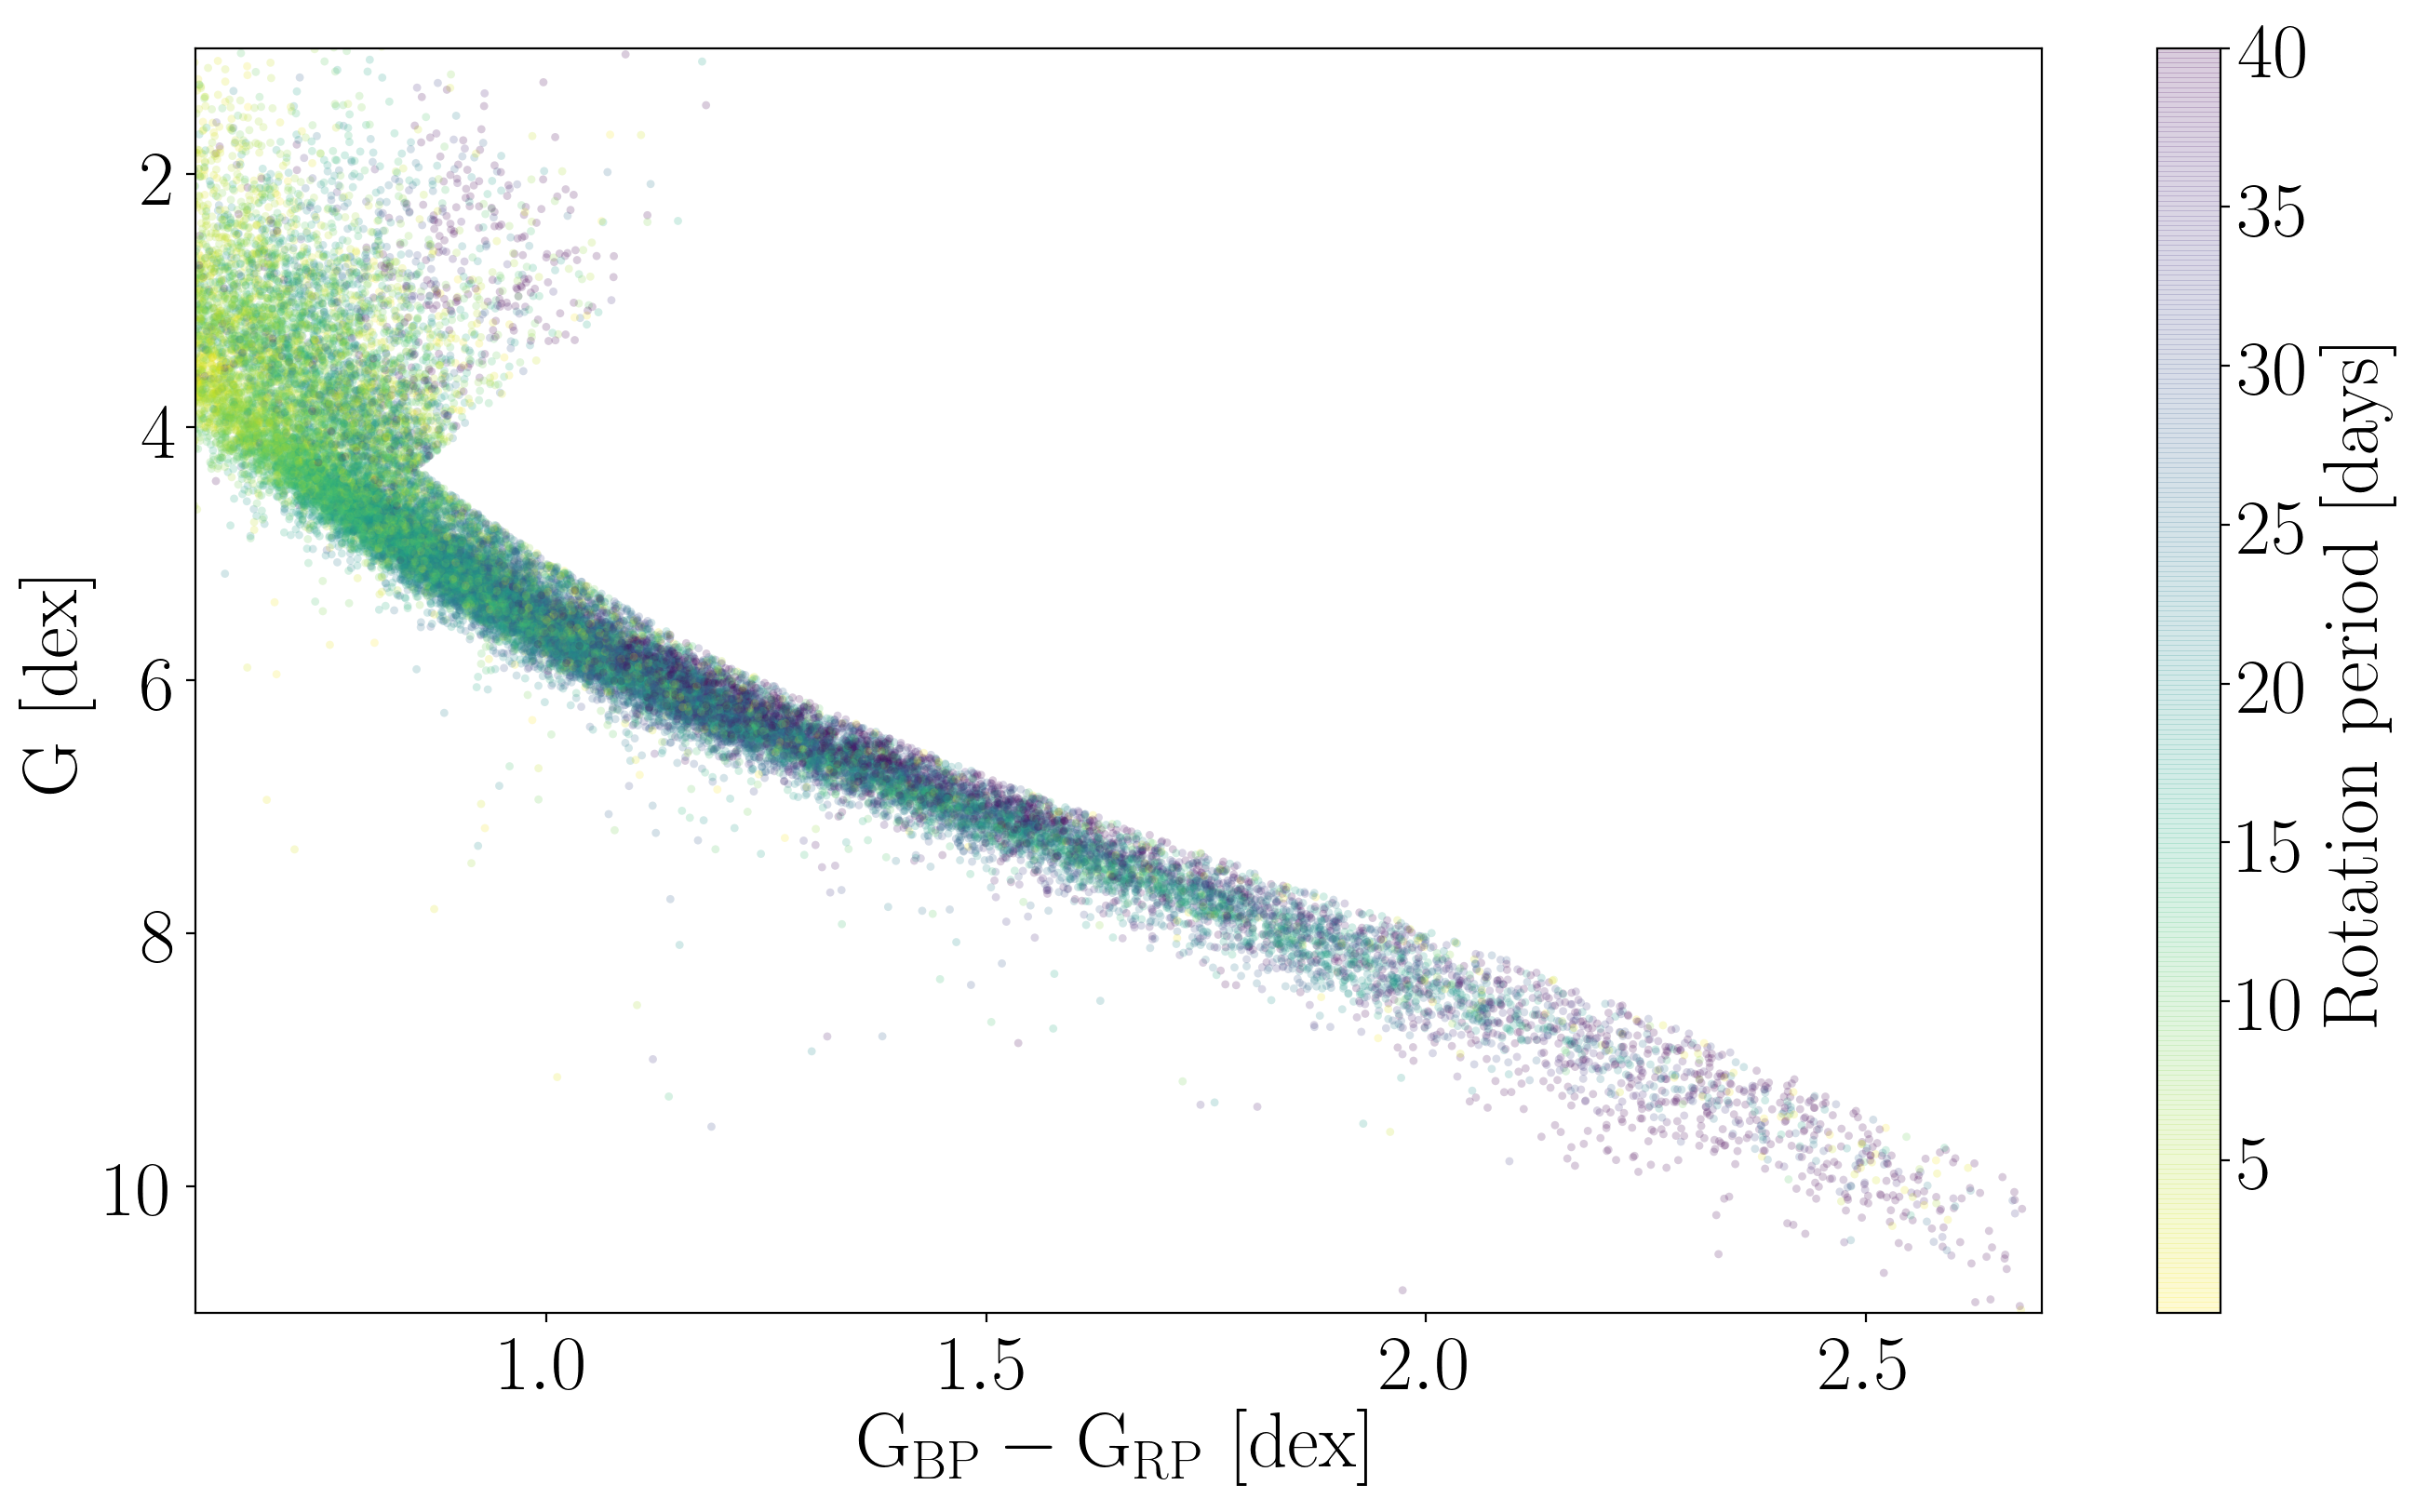

In [66]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.bp_dered-df.rp_dered, df.abs_G, c=df.Prot,
            s=10, alpha=.2, cmap="viridis_r", vmax=40, zorder=1,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.6, 2.7);

In [67]:
df.to_pickle("Mc_Gar_Sant_no_visual_binaries.pkl")